### Untapped Energy Quantitative Challenge

#### Load model and scaler and attempt predicting CH4 emmissions from the competition set in Kaggle

In [1]:
#Load model and scaler
import warnings
warnings.filterwarnings('ignore')

from pickle import load
from tensorflow import keras
from keras.models import Sequential

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import matplotlib.image as mpimg

Using TensorFlow backend.


### Load Model and Scaler

In [2]:
# Load h5 model and scaler
model = keras.models.load_model('Reduced_PlumeOnly_CNN_Rev14_preScld_MinMax_4CV2_4D_DO_25_adam_Ep37.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [3]:
scaler = load(open('scaler_rev14.pkl', 'rb'))

In [4]:
Results = pd.read_csv('New_Competition_Images/2023-ch4-emissions-datathon/sample_submission_sample2.csv')

In [5]:
Folder_Path = 'New_Competition_Images/2023-ch4-emissions-datathon/testfiles2/'

In [6]:
# Load competition image list file and load corresponding images
comp_list = pd.read_csv('Comp2_file_names.csv')
comp_list

,test2_file_names
0,01A.png
1,02A.png
2,03A.png
3,04A.png
4,05A.png
5,06A.png
6,07A.png
7,08A.png
8,09A.png
9,10A.png


### Load and Resize Competition Image set to (160, 160)

In [7]:
from PIL import Image

In [8]:
def Load_and_Resize(Fpath, size):
    img = Image.open(Fpath) 
    img = img.resize(size)
    img = np.asarray(img)/255
    return img

In [9]:
def Resize_Filter_for_Red_Purple_Plume(Path, Size, color):
    a, b = 0, 3
    img1 = Image.open(Path)
    img1 = img1.resize(Size)
    img1 = np.asarray(img1)/255
    #Red Plume Processing
    if color == 'red':
        img1[:,:,b] = np.multiply(img1[:,:,b] ,  img1[:,:,a] >= 0.95  )
        return img1
    #Purple Plume Processing
    else:
        img2 = Image.open(Path)
        img2 = img2.resize(Size)
        img2 = np.asarray(img2)/255
        img3 = Image.open(Path)
        img3 = img3.resize( Size)
        img3 = np.asarray(img3)/255       
       
        #Capture Red
        img3[:,:,b] = np.multiply(img3[:,:,b] ,  img3[:,:,a] >= 0.95  )
        #Capture green / yellow 
        img1[:,:,b] = np.multiply(img1[:,:,b] ,  img1[:,:,a+1] >= 0.8  )
        #print(img1.shape)
        img1[:,:,b] = np.multiply( img1[:,:, b] ,  img1[:,:,a+1] <= 0.9 )
        #print(img1.shape)
        #Capture Purple
        img2[:,:,b] = img2[:,:, b] * ( img2[:,:,a+2] >= 0.75 )
        # Merge
        img2[:,:,b] = img2[:,:,b] * (img2[:,:,b] > img1[:,:,b] ) + img1[:,:,b] * (img1[:,:,b] > img2[:,:,b]) + img2[:,:,b] * (img2[:,:,b] == img1[:,:,b])
    
        img3[:,:,b] = img2[:,:,b] * (img2[:,:,b] > img3[:,:,b] ) + img3[:,:,b] * (img3[:,:,b] > img2[:,:,b]) + img2[:,:,b] * (img2[:,:,b] == img3[:,:,b])

        return img3

In [10]:
NumImages = len(comp_list)
image_set = np.zeros((NumImages,160,160,4))
raw_set = np.zeros((NumImages, 160,160,4))

In [11]:
# Read image files into the np array
size = (160,160)
for j in range(NumImages):
    Fpath = Folder_Path + comp_list['test2_file_names'].loc[j]
    raw_set[j] = Load_and_Resize(Fpath, size)
    image_set[j] = Resize_Filter_for_Red_Purple_Plume(Fpath, size, 'purple')

In [12]:
image_set.shape

(20, 160, 160, 4)

Image Preview


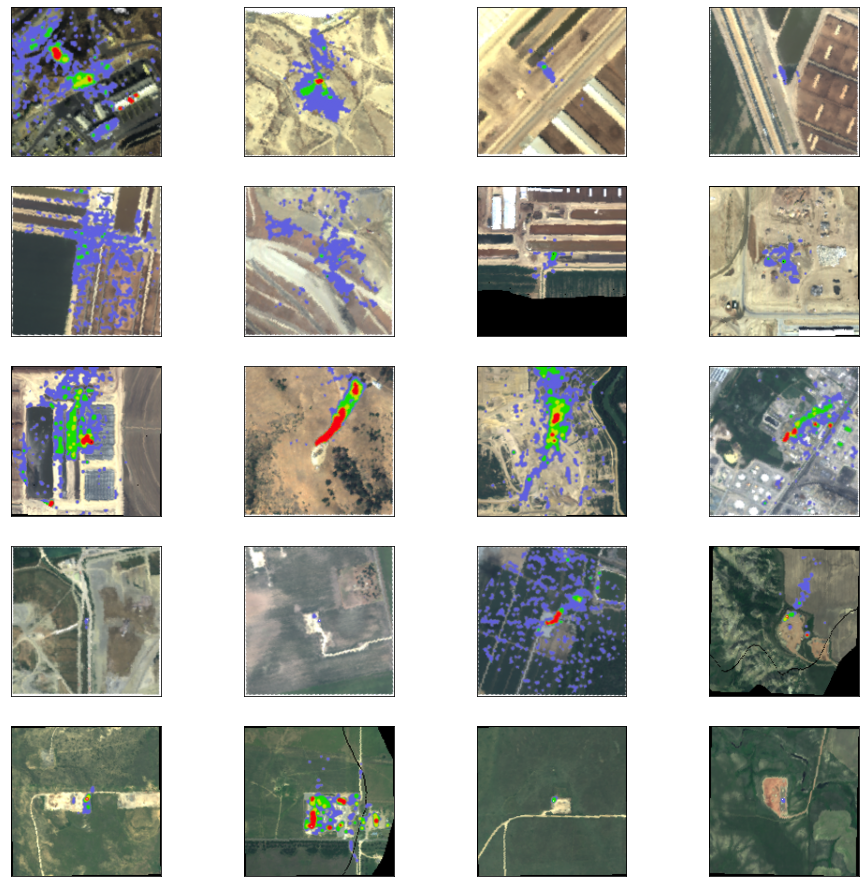

In [13]:
# Preview Competition Images 
print('Image Preview')
plt.figure(figsize=(16,16))

for i in range(len(raw_set)):  
    plt.subplot(5,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(raw_set[i])
    #plt.xlabel(str(int(plume_list['qplume'].loc[i])), fontsize = 24 )

plt.show()

Processed Image Preview


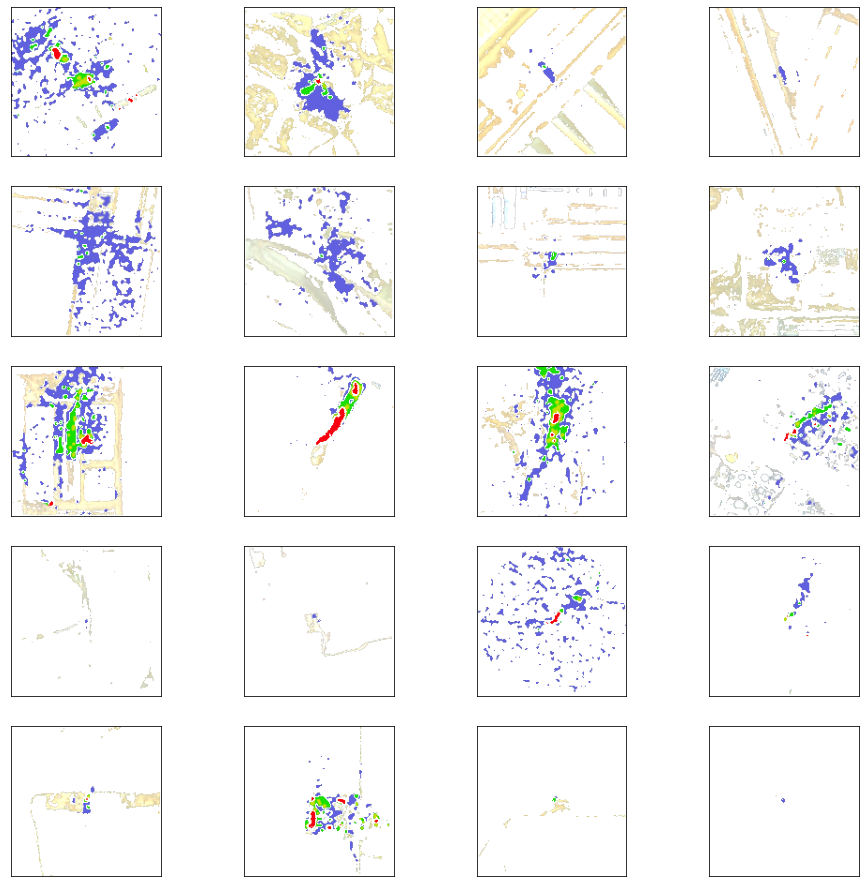

In [14]:
# Preview Competition Images 
print('Processed Image Preview')
plt.figure(figsize=(16,16))

for i in range(len(image_set)):  
    plt.subplot(5,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_set[i])
    #plt.xlabel(str(int(plume_list['qplume'].loc[i])), fontsize = 24 )

plt.show()

In [15]:
ypred = (model.predict(image_set))
ypred

array([[0.146113  ],
       [0.12919429],
       [0.05131101],
       [0.04345945],
       [0.10692325],
       [0.0545305 ],
       [0.05061704],
       [0.05517763],
       [0.18884856],
       [0.24253614],
       [0.30947512],
       [0.08896894],
       [0.04091828],
       [0.046692  ],
       [0.1388571 ],
       [0.06871745],
       [0.0546791 ],
       [0.18760751],
       [0.04254322],
       [0.03511561]], dtype=float32)

In [16]:
ypred_scld = np.power(scaler.inverse_transform(ypred), (4/3))
ypred_scld

array([[ 939.4245 ],
       [ 802.494  ],
       [ 254.5272 ],
       [ 208.8976 ],
       [ 630.89233],
       [ 273.8697 ],
       [ 250.4047 ],
       [ 277.8    ],
       [1307.6349 ],
       [1809.6805 ],
       [2488.0015 ],
       [ 500.49005],
       [ 194.62549],
       [ 227.4102 ],
       [ 880.0405 ],
       [ 363.09482],
       [ 274.771  ],
       [1296.5247 ],
       [ 203.72264],
       [ 163.01517]], dtype=float32)

Image Preview with Predicted Emmision Rate Sub#9 and Model 14 EP37


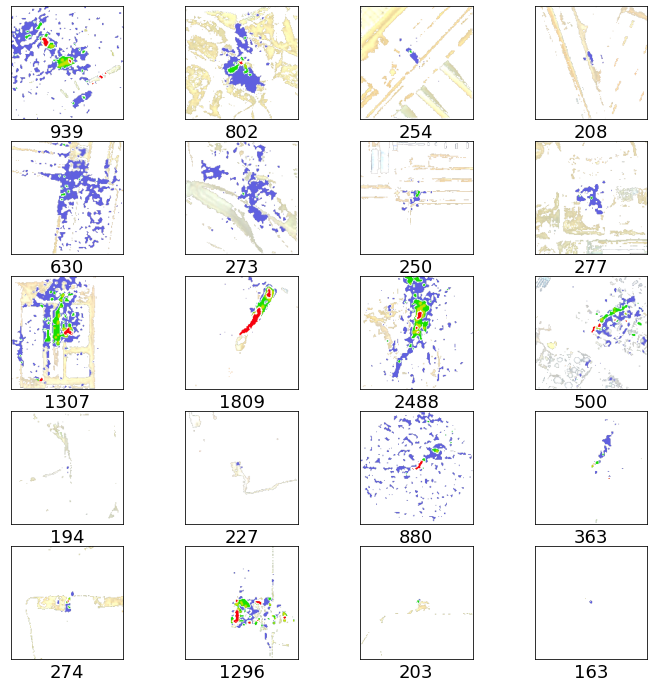

In [20]:
# Preview Competition Images 
print('Image Preview with Predicted Emmision Rate Sub#9 and Model 14 EP37')
plt.figure(figsize=(12,12))

for i in range(len(image_set)):  
    plt.subplot(5,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_set[i])
    #plt.xlabel(str(int(ypred_scld[i])), fontsize = 24 )
    #plt.xlabel(str(int(Results.iloc[i,1]) )+ ' ' + str(int(Results.iloc[i,2]) ), fontsize = 24 ) 
    plt.xlabel(str(int(ypred_scld[i]) ), fontsize = 18 ) 

plt.show()

In [18]:
Results['MethaneRate_Actual'] = ypred_scld
Results

,source_ID,MethaneRate_Actual
0,01A,939.424500
1,02A,802.494019
2,03A,254.527206
3,04A,208.897598
4,05A,630.892334
5,06A,273.869690
6,07A,250.404694
7,08A,277.799988
8,09A,1307.634888
9,10A,1809.680542


In [19]:
Results.to_csv('New_Competition_Images/DreamTeam_PNG_Subm9_w_Model_Rev14_Ep37.csv', index = False)